In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

import time
import random
import re

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tqdm import tqdm

In [2]:
data_path = 'gecodb_v01.tsv'

### Отбор данных [1 балл]

In [3]:
df = pd.read_csv(data_path, sep='\t', header=None)

In [4]:
df.columns = ['Word', 'Count']

In [5]:
df.head()

,Word,Count
0,Zeit_Punkt,825790
1,Web_Seite,532934
2,Bund_+es_Regierung,437277
3,Welt_Krieg,419007
4,Mittel_Punkt,415822


In [6]:
df.shape

(22380133, 2)

Для начала отберём из множества слов только те, которые в качестве разделителя имеют ТОЛЬКО нижнее подчёркивание. Также не забываем о существовании букв немецкого алфавита. Регулярные выражения вам в помощь! :)

In [7]:
data = ...
data.shape

(5657833, 2)

Разумеется, вы можете взять больше слов, всё зависит от возможностей вашего компьютера. В нашем случае мы берём миллион слов.

In [8]:
data = data.sample(n=1000000)

Теперь посмотрим на количество нижних подчёркиваний в словах. Такая информация нам пригодится для разделения данных на тренировочную и тестовую выборки. Обе выборки должны получиться репрезентативными.

In [9]:
underscores_counts = ...

In [10]:
underscores_counts.describe()

count    1000000.000000
mean           1.294369
std            0.495308
min            0.000000
25%            1.000000
50%            1.000000
75%            2.000000
max            6.000000
dtype: float64

<AxesSubplot:>

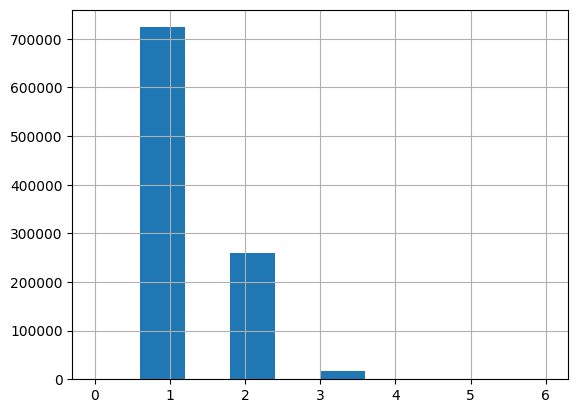

In [11]:
underscores_counts.hist()

<AxesSubplot:>

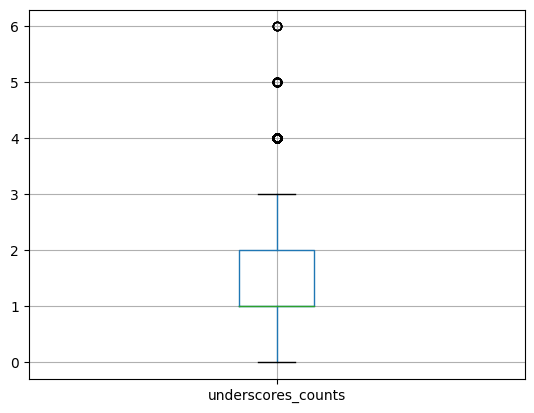

In [12]:
pd.DataFrame({'underscores_counts': underscores_counts}).boxplot()

In [13]:
underscores_counts.value_counts()

1    723552
2    259342
3     16336
4       721
5        41
6         6
0         2
dtype: int64

Создадим словари символов и тегов

In [14]:
chars = set([ch.lower() for word in data['Word'].values for ch in word if ch not in '_+'])
len(chars)

30

In [15]:
TAGS = (0, 1, 2)

char2index = {ch: i + 2 for i, ch in enumerate(list(chars))}
char2index['-OOV-'] = 1
char2index['-PAD-'] = 0
char2index[None] = 1

In [16]:
len(char2index)

33

### Простая разметка и разбиение данных на обучающую и тестовую выборку [2 балла]

Теперь будем кодировать слова.

Для начала будем считать, что выходная последовательность состоит из двух чисел. Цифрой `1` будем указывать границу подстроки, то есть символ, стоящий перед `_`. В остальных случаях заполняем последовательность нулями.

Итак, заполним позиции символов следующим образом:

`0 - <Word-In>`

`1 - <Word-End>`

In [2]:
def simple_compound_annotation(word):
    seq = []
    # YOUR CODE HERE
    return str(seq)

In [18]:
simple_compound_annotation('Zeit_Punkt')

'[0, 0, 0, 1, 0, 0, 0, 0, 0]'

In [19]:
data['Annotation'] = data['Word'].apply(simple_compound_annotation)

In [21]:
data['Underscores'] = ...

In [22]:
data.head(3)

,Word,Count,Annotation,Underscores
6852014,Raum_Vergeudung,2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1
17324266,Holz_Papier_Produktion,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2
4824675,Spiel_Tag_Info,3,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]",2


Перемешаем слова, чтобы они не следовали в алфавитном порядке.

In [20]:
data = shuffle(data)
data.head(10)

,Word,Count,Annotation
6852014,Raum_Vergeudung,2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
17324266,Holz_Papier_Produktion,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4824675,Spiel_Tag_Info,3,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]"
12674489,Router_Vorschlag,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
737480,Tür_Beleuchtung,41,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1552836,Lot_Strecke,15,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1058363,Symbol_Befehl,25,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
2911165,Trojaner_Signatur,6,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4836133,Sound_Choreographie,3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8102670,frisch_Käse_Laib,2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]"


Разделим выборку на тренировочную и тестовую. Обратим внимание, что в распределении больше всего двусложных и трёхсложных слов. Поэтому мы их в первую очередь и возьмём в обучающие данные. А большую часть многосложных слов (особенно если их совсем немного) отправим в тестовую выборку.

На всякий случай, мы не берём в выборку слова, которые не содержат никаких подчёркиваний :)

Также никто не мешает вам создать валидационную выборку и потом корректировать по ней качество модели :)

In [27]:
train = ...
val = ...
test = ...

In [28]:
train.shape, test.shape

((699461, 4), (300537, 4))

In [29]:
train = shuffle(train)
test = shuffle(test)

In [30]:
train.Underscores.value_counts()

1    506632
2    181323
3     11506
Name: Underscores, dtype: int64

In [31]:
test.Underscores.value_counts()

1    216920
2     78019
3      4830
4       721
5        41
6         6
Name: Underscores, dtype: int64

In [70]:
def list2tensor(l):
    return torch.tensor(l, dtype=torch.long)

def encode_sentences(words):
    """
    Напишите функцию, кодирующую слова в последовательности символьных кодов
    Обратите внимание на то, чтобы функция умела обрабатывать символы, которых нет в словаре.
    Также не забываёте о том, что все нижние подчёркивания и маркеры для инфиксов должны быть удалены из слов.
    Чтобы быстрее обрабатывать слова, рекомендуется вместо питоновских списков использвать функцию np.zeros(...) 
    и затем добавлять код символа по индексу
    
    :param words: список слов
    ":return массив с тензорами, состоящими из символьных кодов"
    """
    words_X = []
    # YOUR CODE HERE
    return words_X

def encode_tags(tags):
    return [list2tensor(eval(ts)) for ts in tags]

In [33]:
train_x, train_y = encode_sentences(train['Word'].values), encode_tags(train['Annotation'].values)

In [34]:
test_x, test_y = encode_sentences(test['Word'].values), encode_tags(test['Annotation'].values)

### Разделитель слов [2 балла] (+1 за валидационную выборку)

Построим сегментатор на основе символьной языковой модели.

In [35]:
class BiLSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, dropout=0.2):
        super(BiLSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embeddings = ... # строим symbol2vec-матрицу
        self.bilstm = ... # двунаправленный LSTM-слой
        self.dense = ... # обычный fc-layer
        self.dropout = ...

    def forward(self, word):
        """
        Напишите код для архитектуры сети
        В конце вам может пригодиться softmax
        """
        # YOUR CODE HERE
        return tag_scores

Обучение

In [40]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 32
N_EPOCHS = 3
N_TAGS = 2

In [41]:
model = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(char2index), N_TAGS)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [42]:
sum(p.numel() for p in model.parameters())

18082

In [ ]:
@torch.no_grad()
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    model.eval()
    # YOUR CODE HERE
    # Берите любые метрики, которые хотите оценивать на валидационной выборке

In [43]:
for epoch in range(N_EPOCHS): 
    model.train()
    running_loss = 0.0
    for i, (word_in, targets) in enumerate(zip(train_x, train_y)):
        model.zero_grad()
        tag_scores = model(word_in)
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        
        # print statistics
        
        running_loss += loss.item()
        if i % 10000 == 9999:
            print(f'[{epoch + 1}, {i + 1:5d}/{len(train_x)}] loss: {running_loss / 10000:.3f}')
            running_loss = 0.0
            
    ### ЗДЕСЬ МОЖЕТ БЫТЬ ВАША (РЕКЛАМА!) ВАЛИДАЦИОННАЯ ВЫБОРКА
    print_metrics(model, val_data, max_len=128)

[1, 10000/699461] loss: 0.288
[1, 20000/699461] loss: 0.250
[1, 30000/699461] loss: 0.219
[1, 40000/699461] loss: 0.200
[1, 50000/699461] loss: 0.188
[1, 60000/699461] loss: 0.173
[1, 70000/699461] loss: 0.162
[1, 80000/699461] loss: 0.153
[1, 90000/699461] loss: 0.145
[1, 100000/699461] loss: 0.138
[1, 110000/699461] loss: 0.134
[1, 120000/699461] loss: 0.131
[1, 130000/699461] loss: 0.128
[1, 140000/699461] loss: 0.124
[1, 150000/699461] loss: 0.123
[1, 160000/699461] loss: 0.116
[1, 170000/699461] loss: 0.115
[1, 180000/699461] loss: 0.115
[1, 190000/699461] loss: 0.111
[1, 200000/699461] loss: 0.109
[1, 210000/699461] loss: 0.107
[1, 220000/699461] loss: 0.107
[1, 230000/699461] loss: 0.102
[1, 240000/699461] loss: 0.102
[1, 250000/699461] loss: 0.102
[1, 260000/699461] loss: 0.102
[1, 270000/699461] loss: 0.098
[1, 280000/699461] loss: 0.098
[1, 290000/699461] loss: 0.097
[1, 300000/699461] loss: 0.097
[1, 310000/699461] loss: 0.094
[1, 320000/699461] loss: 0.094
[1, 330000/699461

In [44]:
predicts = ...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 213874/300537 [05:07<02:02, 707.92it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [45]:
y_true = [l for seq in test_y for l in seq]
y_pred = [l for seq in predicts for l in seq]

In [46]:
target_names = ('Word-In', 'Word-End')

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Word-In       0.99      0.99      0.99   3961250
    Word-End       0.91      0.88      0.89    390573

    accuracy                           0.98   4351823
   macro avg       0.95      0.94      0.94   4351823
weighted avg       0.98      0.98      0.98   4351823



### Усложним нашу разметку для инфиксов [1 балл]

Пусть нашему инфиксу будет присваиваться код 2 (`Infix-End`). В итоге мы будем иметь три тега.

In [84]:
def encode_complex_compound_annotation(word):
    seq = []
    # YOUR CODE HERE
    return str(seq)

In [85]:
encode_complex_compound_annotation('Vertrieb_+s_Netz_Planung')

'[0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]'

### Обучите ту же модель для новой разметки [4 балла] (+1 за валидационную выборку)

1. Объединим первую обучающую выборку с подвыборкой, в которой находятся инфиксы. Размер подвыборки с инфиксами возьмите в таком расчёте: `x = (количество_слов_с_инфиксами * N_sample)/(количество_слов_только_с_подчёркиванием)`, где `N_sample` - число слов только с подчёркиванием, которые мы взяли в первой выборке

 - N_sample в нашем случае равен 1000000
 - количество_слов_только_с_подчёркиванием, количество_слов_с_инфиксами - ответ находится в команде shape
 
2. Запускаем обучение
3. Оцениваем качество и описываем выводы

В пункте 1 не забываем разделить выборку на train и test :)

In [100]:
infixes_data['Annotation'] = infixes_data['Word'].apply(encode_complex_compound_annotation)

In [102]:
full_train = ...
full_val = ...
full_test = ...

Обучение

In [113]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 32
N_EPOCHS = 3
N_TAGS = 3

In [114]:
model = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(char2index), N_TAGS)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
sum(p.numel() for p in model.parameters())